In [1]:
from pyspark.sql import functions as F
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import folium
from folium.plugins import HeatMap, MarkerCluster
from pyspark.ml.feature import StringIndexer, OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2
import sys; 
import sys; sys.path.insert(0, 'lib/')
from libs import utils, genetic_algo

In [3]:
data_path = "data/Crime_Data_from_2020_to_Present_20241013.csv"
# Read and Clean Data
spark = utils.start_spark()
df = utils.prepare_data(spark, data_path)
# Additional feature engineering - add more features
df = utils.feature_engineering(df)
columns_drop = ["AREA NAME", "Rpt Dist No", "Part 1-2", "Crm Cd", "Crm Cd Desc", "Mocodes", "Premis Cd","Premis Desc", "Weapon Used Cd", "Weapon Desc", "Status Desc", "LOCATION", "age_group"]
df_dropped = utils.drop_columns(df, columns_drop)
df_dropped = df_dropped.drop("DATE OCC", "TIME OCC", "datetime_str", "Date Rptd")
df_clean = df_dropped.dropna(subset=["Vict Age"])


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/04 14:34:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


After cleaning and processing the data, using the entire dataset. 

In [4]:
df_pd = df_clean.toPandas()
df_pd_encoded = pd.get_dummies(df_pd, columns=["Vict Sex", "Vict Descent", "Status", "Category"], drop_first=True)
df_pd_encoded

24/11/04 14:34:12 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


,AREA,Vict Age,LAT,LON,Year OCC,Month OCC,Day OCC,Vict Sex_M,Vict Sex_X,Vict Descent_Asian Indian,...,Category_MVT (GTA),Category_OTHER THEFT,Category_PERSONAL THFT,Category_RAPE,Category_ROBBERY,Category_SIMPLE ASSAULT,Category_SIMPLE ASSAULT (DV),Category_Trespassing,Category_Unknown,Category_Vandalism
0,1,47,34.0444,-118.2628,2020,2,8,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,3,19,34.0210,-118.3002,2020,11,4,False,True,False,...,False,True,False,False,False,False,False,False,False,False
2,9,19,34.1576,-118.4387,2020,3,10,True,False,False,...,False,True,False,False,False,False,False,False,False,False
3,6,28,34.0944,-118.3277,2020,8,17,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,18,41,33.9467,-118.2463,2020,12,1,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722901,16,36,34.2271,-118.3878,2024,1,13,True,False,False,...,False,False,False,False,False,False,False,False,False,False
722902,21,44,34.2260,-118.6214,2024,2,17,False,False,False,...,False,False,False,False,False,False,False,False,False,False
722903,20,80,34.0690,-118.3054,2024,1,16,False,False,False,...,False,False,False,False,False,True,False,False,False,False
722904,20,36,34.0617,-118.3066,2024,8,17,False,False,False,...,False,True,False,False,False,False,False,False,False,False


In [5]:
utils.stop_spark(spark)

# Clustering using DBSCAN

In [6]:
dbscan = DBSCAN(eps=3, min_samples = 10)
clusters = dbscan.fit_predict(df_pd_encoded)

In [7]:
labels = dbscan.labels_
df_pd_encoded["cluster"] = labels
hotspots = df_pd_encoded[df_pd_encoded["cluster"]!=-1]
heatmap_data = list(zip(hotspots['LAT'], hotspots['LON']))

## Plot the result of the clustering in Scatter Plot
Using seaborn

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [9]:
hotspots.head()

,AREA,Vict Age,LAT,LON,Year OCC,Month OCC,Day OCC,Vict Sex_M,Vict Sex_X,Vict Descent_Asian Indian,...,Category_OTHER THEFT,Category_PERSONAL THFT,Category_RAPE,Category_ROBBERY,Category_SIMPLE ASSAULT,Category_SIMPLE ASSAULT (DV),Category_Trespassing,Category_Unknown,Category_Vandalism,cluster
0,1,47,34.0444,-118.2628,2020,2,8,True,False,False,...,False,False,False,False,False,False,False,False,False,0
1,3,19,34.0210,-118.3002,2020,11,4,False,True,False,...,True,False,False,False,False,False,False,False,False,0
2,9,19,34.1576,-118.4387,2020,3,10,True,False,False,...,True,False,False,False,False,False,False,False,False,0
3,6,28,34.0944,-118.3277,2020,8,17,True,False,False,...,False,False,False,False,False,False,False,False,False,0
4,18,41,33.9467,-118.2463,2020,12,1,True,False,False,...,False,False,False,False,False,False,False,False,False,0


/Users/siowchuen/anaconda3/envs/pyspark_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


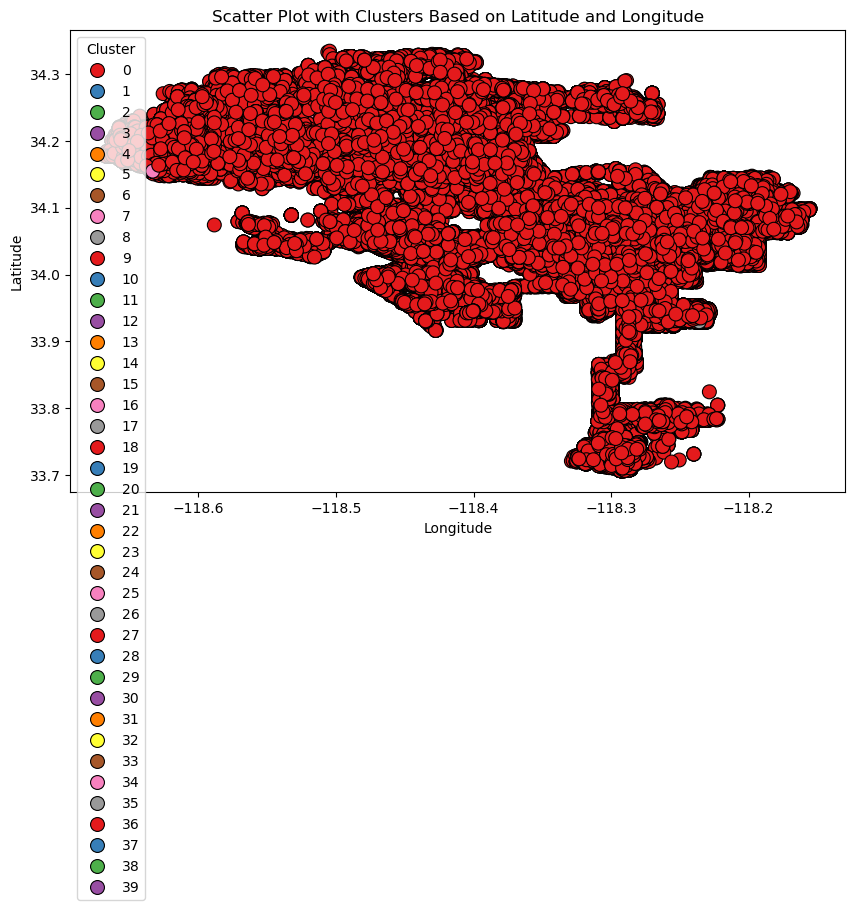

In [10]:
# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='LON', 
    y='LAT', 
    hue='cluster',    # color by cluster label
    palette='Set1',   # color palette for clusters
    data=hotspots, 
    s=100,            # marker size
    edgecolor='k'     # marker edge color
)

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot with Clusters Based on Latitude and Longitude')
plt.legend(title='Cluster')
plt.show()

Results is showing too many overlapping dots. But could be because we set the min_samples to 10 where there is a high crime rate.

## Plot the clustering result with HeatMap
Not the most ideal, but plotting on Map is too much graphic power. 

In [11]:
m =  folium.Map(location=[hotspots['LAT'].mean(), hotspots['LON'].mean()], zoom_start=12)

# Add the heatmap layer
HeatMap(heatmap_data, radius=15, blur=10).add_to(m)
filename = f"heatmaps/crime_hotspots_all_dbscan_3.html"
# Show the map (or save to file)
m.save(filename)

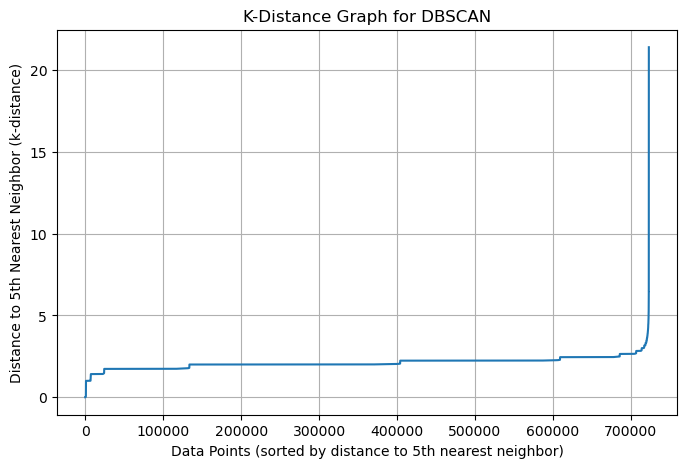

In [17]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(df_pd_encoded)

distances, indices = neighbors_fit.kneighbors(df_pd_encoded)
distances = np.sort(distances[:, 4])

plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('K-Distance Graph for DBSCAN')
plt.xlabel('Data Points (sorted by distance to 5th nearest neighbor)')
plt.ylabel('Distance to 5th Nearest Neighbor (k-distance)')
plt.grid(True)
plt.show()


## Crime Severity based Clustering
With the majority of the crime reported are theft or property crimes. There could be 2 different approaches on how we can reduce crime rates in LA, with data-driven insights. First way is focusing on reducing the crime rate where we focus on the highest reported category of crime. The second way is to put human life first by focusing on reducing violent crime. 

With that stated, we can see that from EDA BTFV is the highest crime reported.about 15.3%. We will start from there.  

In [13]:
df_pd_clean = df_pd

In [14]:
df_btfv = df_pd_clean[df_pd_clean['Category'] == "BTFV"]
df_btfv.head()

,AREA,Vict Age,Vict Sex,Vict Descent,Status,LAT,LON,Year OCC,Month OCC,Day OCC,Category
0,1,47,M,Other,IC,34.0444,-118.2628,2020,2,8,BTFV
27,11,20,M,Other Asian,IC,34.1192,-118.3004,2020,5,8,BTFV
54,11,34,F,White,IC,34.1428,-118.2261,2020,6,27,BTFV
68,15,18,F,Hispanic/Latin/Mexican,IC,34.1412,-118.3681,2020,12,27,BTFV
70,3,27,F,Other,IC,34.0191,-118.2977,2020,9,11,BTFV


In [15]:
df_btfv_encoded = pd.get_dummies(df_btfv, columns=["Vict Sex", "Vict Descent", "Status", "Category"], drop_first=True)


### BTFV Clustering with DBSCAN

In [16]:
dbscan_btfv = DBSCAN(eps=3, min_samples = 100)
dbscan_clusters_btfv = dbscan_btfv.fit_predict(df_btfv_encoded)

In [17]:
dbscan_btfv_labels = dbscan_btfv.labels_
df_btfv_encoded["dbscan_clusters"] = dbscan_btfv_labels
dbscan_btfv_hotspots = df_btfv_encoded[df_btfv_encoded["dbscan_clusters"]!=-1]


In [18]:
num_of_clusters = len(dbscan_btfv_hotspots['dbscan_clusters'].unique())

In [19]:
dbscan_btfv_hotspots[["LAT", "LON", "dbscan_clusters"]].groupby("dbscan_clusters").count()

,LAT,LON
dbscan_clusters,,
0,2199,2199
1,734,734
2,403,403
3,92,92
4,138,138
5,647,647
6,101,101
7,105,105
8,170,170


In [20]:
dbscan_btfv_hotspots[dbscan_btfv_hotspots["dbscan_clusters"]==0]

,AREA,Vict Age,LAT,LON,Year OCC,Month OCC,Day OCC,Vict Sex_M,Vict Sex_X,Vict Descent_Asian Indian,...,Vict Descent_Samoan,Vict Descent_Unknown,Vict Descent_Vietnamese,Vict Descent_White,Status_AO,Status_CC,Status_IC,Status_JA,Status_JO,dbscan_clusters
1528,1,29,34.0364,-118.2677,2020,2,17,False,False,False,...,False,False,False,False,False,False,True,False,False,0
2114,3,29,34.0276,-118.3236,2020,3,18,True,False,False,...,False,False,False,True,False,False,True,False,False,0
4879,2,26,34.0606,-118.2568,2020,8,22,False,False,False,...,False,False,False,False,False,False,True,False,False,0
5020,1,30,34.0472,-118.2352,2020,6,20,True,False,False,...,False,False,False,False,False,False,True,False,False,0
5382,2,30,34.0885,-118.2979,2020,7,19,True,False,False,...,False,False,False,False,False,False,True,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721641,1,28,34.0461,-118.2395,2024,8,16,True,False,False,...,False,False,False,False,False,False,True,False,False,0
721933,1,29,34.0459,-118.2579,2024,7,16,False,False,False,...,False,False,False,True,False,False,True,False,False,0
722252,1,29,34.0498,-118.2400,2024,9,18,False,False,False,...,False,False,False,True,False,False,True,False,False,0
722602,1,24,34.0452,-118.2569,2024,9,15,False,False,False,...,False,False,False,False,False,False,True,False,False,0


In [90]:
# palette = sns.color_palette("husl", 32)

# # Create scatter plot
# plt.figure(figsize=(10, 6))
# sns.scatterplot(
#     x='LON', 
#     y='LAT', 
#     hue='dbscan_clusters',    # color by cluster label
#     palette=palette,   # color palette for clusters
#     data=dbscan_btfv_hotspots, 
#     s=10,            # marker size
#     edgecolor='k'     # marker edge color
# )

# # Add labels and title
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('Scatter Plot with Clusters Based on Latitude and Longitude for all clusters')
# plt.legend(title='Cluster')
# plt.show()

Plot the clustering separately on each plot since there are quite a bit of overlap

In [91]:
# for i in range(num_of_clusters):
#     cluster_data = dbscan_btfv_hotspots[dbscan_btfv_hotspots["dbscan_clusters"]==i]
#     plt.figure(figsize=(10, 6))
#     sns.scatterplot(
#         x='LON', 
#         y='LAT', 
#         hue='dbscan_clusters',    # color by cluster label
#         palette=palette,   # color palette for clusters
#         data=cluster_data, 
#         s=10,            # marker size
#         edgecolor='k'     # marker edge color
#     )

#     # Add labels and title
#     plt.xlabel('Longitude')
#     plt.ylabel('Latitude')
#     plt.title(f'Scatter Plot for cluster {i}')
#     plt.legend(title='Cluster')
#     plt.show()

Plot Cluster 1 on a map for better visualization.

In [55]:
import folium


(2199, 33)

In [95]:
# Initialize map centered around mean latitude and longitude
m = folium.Map(location=[dbscan_btfv_hotspots['LAT'].mean(), dbscan_btfv_hotspots['LON'].mean()], zoom_start=12)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
marker_cluster = MarkerCluster().add_to(m)
# Add points to the map
for i, row in dbscan_btfv_hotspots.iterrows():
    folium.CircleMarker(
        location=(row['LAT'], row['LON']),
        radius=4,
        color=colors[row['dbscan_clusters']],
        fill=True,
        fill_color=colors[row['dbscan_clusters']],
        fill_opacity=0.6,
        popup=f"Cluster: {row['dbscan_clusters']}"
    ).add_to(marker_cluster)

m.save('clusters_btfv_dbscan.html')  # Display map in Jupyter Notebook or save with m.save('map.html')

In [96]:
# Initialize map centered around mean latitude and longitude
m = folium.Map(location=[dbscan_btfv_hotspots['LAT'].mean(), dbscan_btfv_hotspots['LON'].mean()], zoom_start=12)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
# Add points to the map
for i, row in dbscan_btfv_hotspots.iterrows():
    folium.CircleMarker(
        location=(row['LAT'], row['LON']),
        radius=4,
        color=colors[row['dbscan_clusters']],
        fill=True,
        fill_color=colors[row['dbscan_clusters']],
        fill_opacity=0.6,
        popup=f"Cluster: {row['dbscan_clusters']}"
    ).add_to(m)

m.save('markers_btfv_dbscan.html')  # Display map in Jupyter Notebook or save with m.save('map.html')


# Analyse with 2 major crime types
Dividing the crime analysis to 2 major crime types. 
## Violent Crime Clustering

In [23]:
categories_lst = df_pd["Category"].unique()
print(len(categories_lst))
print(categories_lst)

21
['BTFV' 'OTHER THEFT' 'IDENTITY THEFT' 'SIMPLE ASSAULT' 'RAPE'
 'All Other Offenses' 'AGG. ASSAULTS' 'SIMPLE ASSAULT (DV)' 'BURGLARY'
 'ROBBERY' 'AGG. ASSAULTS (DV)' 'FRAUD' 'Vandalism' 'Embezzlement'
 'PERSONAL THFT ' 'ARSON' 'HUMAN TRAFFICKING' 'Trespassing' 'MVT (GTA)'
 'HOMICIDE' 'Unknown']


In [24]:
violent_crime_list = ["SIMPLE ASSAULT", "RAPE", 'AGG. ASSAULTS', "SIMPLE ASSAULT (DV)", "AGG. ASSAULTS (DV)", "ARSON", "HUMAN TRAFFICKING", "Trespassing", "HOMICIDE", "ROBBERY"]
df_pd_2_types = df_pd
df_pd_2_types["Crime Type"] = df_pd_2_types.apply(lambda x: 'Violent' if x['Category'] in violent_crime_list else 'Property', axis=1)
df_pd_2_types.head()

,AREA,Vict Age,Vict Sex,Vict Descent,Status,LAT,LON,Year OCC,Month OCC,Day OCC,Category,Crime Type
0,1,47,M,Other,IC,34.0444,-118.2628,2020,2,8,BTFV,Property
1,3,19,X,Unknown,IC,34.0210,-118.3002,2020,11,4,OTHER THEFT,Property
2,9,19,M,Other,IC,34.1576,-118.4387,2020,3,10,OTHER THEFT,Property
3,6,28,M,Hispanic/Latin/Mexican,IC,34.0944,-118.3277,2020,8,17,IDENTITY THEFT,Property
4,18,41,M,Hispanic/Latin/Mexican,IC,33.9467,-118.2463,2020,12,1,IDENTITY THEFT,Property


In [25]:
df_violent = df_pd_2_types[df_pd_2_types["Crime Type"] == "Violent"]
df_violent.shape
df_violent_encoded = pd.get_dummies(df_violent, columns=["Vict Sex", "Vict Descent", "Status", "Category", "Crime Type"], drop_first=True)
df_violent_encoded.shape

(281280, 40)

In [26]:
dbscan_violent = DBSCAN(eps=3, min_samples = 100)
dbscan_clusters_violent = dbscan_violent.fit_predict(df_violent_encoded)

In [27]:
dbscan_violent_labels = dbscan_violent.labels_
df_violent_encoded["dbscan_clusters"] = dbscan_violent_labels
dbscan_violent_hotspots = df_violent_encoded[df_violent_encoded["dbscan_clusters"]!=-1]

In [28]:
num_of_violent_clusters = len(dbscan_violent_hotspots['dbscan_clusters'].unique())
print(num_of_violent_clusters)

17


In [29]:
dbscan_violent_hotspots[["LAT", "LON", "dbscan_clusters"]].groupby("dbscan_clusters").count()

,LAT,LON
dbscan_clusters,,
0,15647,15647
1,33887,33887
2,29730,29730
3,164,164
4,118,118
5,167,167
6,168,168
7,97,97
8,95,95


In [92]:
m = folium.Map(location=[dbscan_violent_hotspots['LAT'].mean(), dbscan_violent_hotspots['LON'].mean()], zoom_start=12)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
marker_cluster = MarkerCluster().add_to(m)
# Add points to the map
for i, row in dbscan_violent_hotspots.iterrows():
    folium.CircleMarker(
        location=(row['LAT'], row['LON']),
        radius=4,
        color=colors[row['dbscan_clusters']],
        fill=True,
        fill_color=colors[row['dbscan_clusters']],
        fill_opacity=0.6,
        popup=f"Cluster: {row['dbscan_clusters']}"
    ).add_to(marker_cluster)

m.save('clusters_violent_dbscan.html')  # Display map in Jupyter Notebook or save with m.save('map.html')
# m

In [93]:
# Initialize map centered around mean latitude and longitude
m = folium.Map(location=[dbscan_violent_hotspots['LAT'].mean(), dbscan_violent_hotspots['LON'].mean()], zoom_start=12)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
# Add points to the map
for i, row in dbscan_violent_hotspots.iterrows():
    folium.CircleMarker(
        location=(row['LAT'], row['LON']),
        radius=4,
        color=colors[row['dbscan_clusters']],
        fill=True,
        fill_color=colors[row['dbscan_clusters']],
        fill_opacity=0.6,
        popup=f"Cluster: {row['dbscan_clusters']}"
    ).add_to(m)

m.save('markers_violent_dbscan.html')  # Display map in Jupyter Notebook or save with m.save('map.html')
# m

In [32]:
# Plotting the top 3 clusters
# top 3 clusters are 0, 1, 2
violent_top_3_clusters = [0, 1, 2]
df_top3_violent_hotspots = dbscan_violent_hotspots[dbscan_violent_hotspots["dbscan_clusters"].isin(violent_top_3_clusters)]
df_top3_violent_hotspots.shape

(79264, 41)

In [94]:
# Initialize map centered around mean latitude and longitude
m = folium.Map(location=[df_top3_violent_hotspots['LAT'].mean(), df_top3_violent_hotspots['LON'].mean()], zoom_start=12)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
# Add points to the map
for i, row in df_top3_violent_hotspots.iterrows():
    folium.CircleMarker(
        location=(row['LAT'], row['LON']),
        radius=4,
        color=colors[row['dbscan_clusters']],
        fill=True,
        fill_color=colors[row['dbscan_clusters']],
        fill_opacity=0.6,
        popup=f"Cluster: {row['dbscan_clusters']}"
    ).add_to(m)

m.save('markers_top_3_violent_dbscan.html')  # Display map in Jupyter Notebook or save with m.save('map.html')


<Axes: xlabel='LON', ylabel='LAT'>

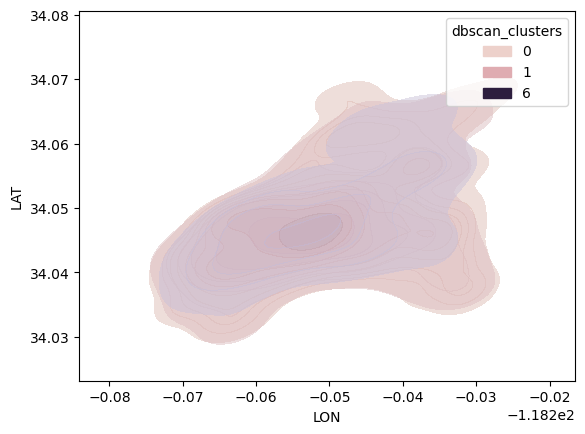

In [95]:
import seaborn as sns

sns.kdeplot(data=df_top3_central_hotspots, x='LON', y='LAT', hue='dbscan_clusters', fill=True, alpha=0.5)